# Hidden Markov Model for Human Activity Recognition

## Project Overview
This notebook implements a Hidden Markov Model (HMM) to recognize human activities (standing, walking, jumping, still) from smartphone accelerometer and gyroscope sensor data.

## 1. Import Required Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.fft import fft, fftfreq
from scipy.stats import skew, kurtosis
import os
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 2. Data Loading and Exploration

In [3]:
DATA_DIR = 'data-recordings'
ACTIVITIES = ['standing', 'walking', 'jumping', 'still']

# Function to load data from a single recording
def load_recording(activity, recording_num):
    """
    Load accelerometer and gyroscope data for a specific recording
    """
    base_path = f'{DATA_DIR}/{activity}/{recording_num}'
    
    # Load accelerometer data
    accel_path = f'{base_path}/Accelerometer.csv'
    accel_df = pd.read_csv(accel_path)
    accel_df.columns = ['time', 'seconds_elapsed', 'accel_z', 'accel_y', 'accel_x']
    
    # Load gyroscope data
    gyro_path = f'{base_path}/Gyroscope.csv'
    gyro_df = pd.read_csv(gyro_path)
    gyro_df.columns = ['time', 'seconds_elapsed', 'gyro_z', 'gyro_y', 'gyro_x']
    
    # Merge on time
    merged_df = pd.merge(accel_df, gyro_df, on=['time', 'seconds_elapsed'], how='inner')
    
    # Add activity label
    merged_df['activity'] = activity
    merged_df['recording'] = recording_num
    
    return merged_df

# Function to load all data
def load_all_data():
    """
    Load all recordings for all activities
    """
    all_data = []
    
    for activity in ACTIVITIES:
        activity_path = f'{DATA_DIR}/{activity}'
        recordings = [d for d in os.listdir(activity_path) if os.path.isdir(f'{activity_path}/{d}')]
        
        print(f"Loading {activity}: {len(recordings)} recordings")
        
        for rec in recordings:
            try:
                df = load_recording(activity, rec)
                all_data.append(df)
                print(f"  ✓ {activity}/{rec}: {len(df)} samples")
            except Exception as e:
                print(f"  ✗ Error loading {activity}/{rec}: {e}")
    
    # Combine all data
    combined_df = pd.concat(all_data, ignore_index=True)
    return combined_df

# Load all data
df_all = load_all_data()

print(f"Total samples loaded: {len(df_all):,}")
print(f"Total recordings: {df_all.groupby(['activity', 'recording']).ngroups}")

# Display sample counts per activity
activity_counts = df_all.groupby('activity').size()
print("\nSamples per activity:")
print(activity_counts)
print()

# Display first few rows
df_all.head()

Loading standing: 3 recordings
  ✓ standing/1: 1079 samples
  ✓ standing/2: 1124 samples
  ✓ standing/3: 1136 samples
Loading walking: 4 recordings
  ✓ walking/1: 1441 samples
  ✓ walking/2: 1748 samples
  ✓ walking/3: 1169 samples
  ✓ walking/4: 1129 samples
Loading jumping: 4 recordings
  ✓ jumping/1: 1074 samples
  ✓ jumping/2: 1199 samples
  ✓ jumping/3: 1138 samples
  ✓ jumping/4: 1506 samples
Loading still: 4 recordings
  ✓ still/1: 1110 samples
  ✓ still/2: 1106 samples
  ✓ still/3: 1166 samples
  ✓ still/4: 1119 samples
Total samples loaded: 18,244
Total recordings: 15

Samples per activity:
activity
jumping     4917
standing    3339
still       4501
walking     5487
dtype: int64



,time,seconds_elapsed,accel_z,accel_y,accel_x,gyro_z,gyro_y,gyro_x,activity,recording
0,1761140347705679000,0.057679,-0.471378,-0.362375,-0.321642,-0.163648,0.066371,-0.339765,standing,1
1,1761140347715738000,0.067738,-0.717251,-0.209294,0.053302,-0.168990,0.018039,-0.213935,standing,1
2,1761140347725798100,0.077798,-0.737952,0.004931,0.324414,-0.125884,-0.030391,-0.078184,standing,1
3,1761140347735857400,0.087857,-0.639918,0.191747,0.441891,-0.078009,-0.070773,0.020151,standing,1
4,1761140347745917400,0.097917,-0.391541,0.211366,0.503254,-0.031247,-0.103880,0.066521,standing,1


## 3. Data Visualization

Let's visualize the raw sensor signals to understand the differences between activities.

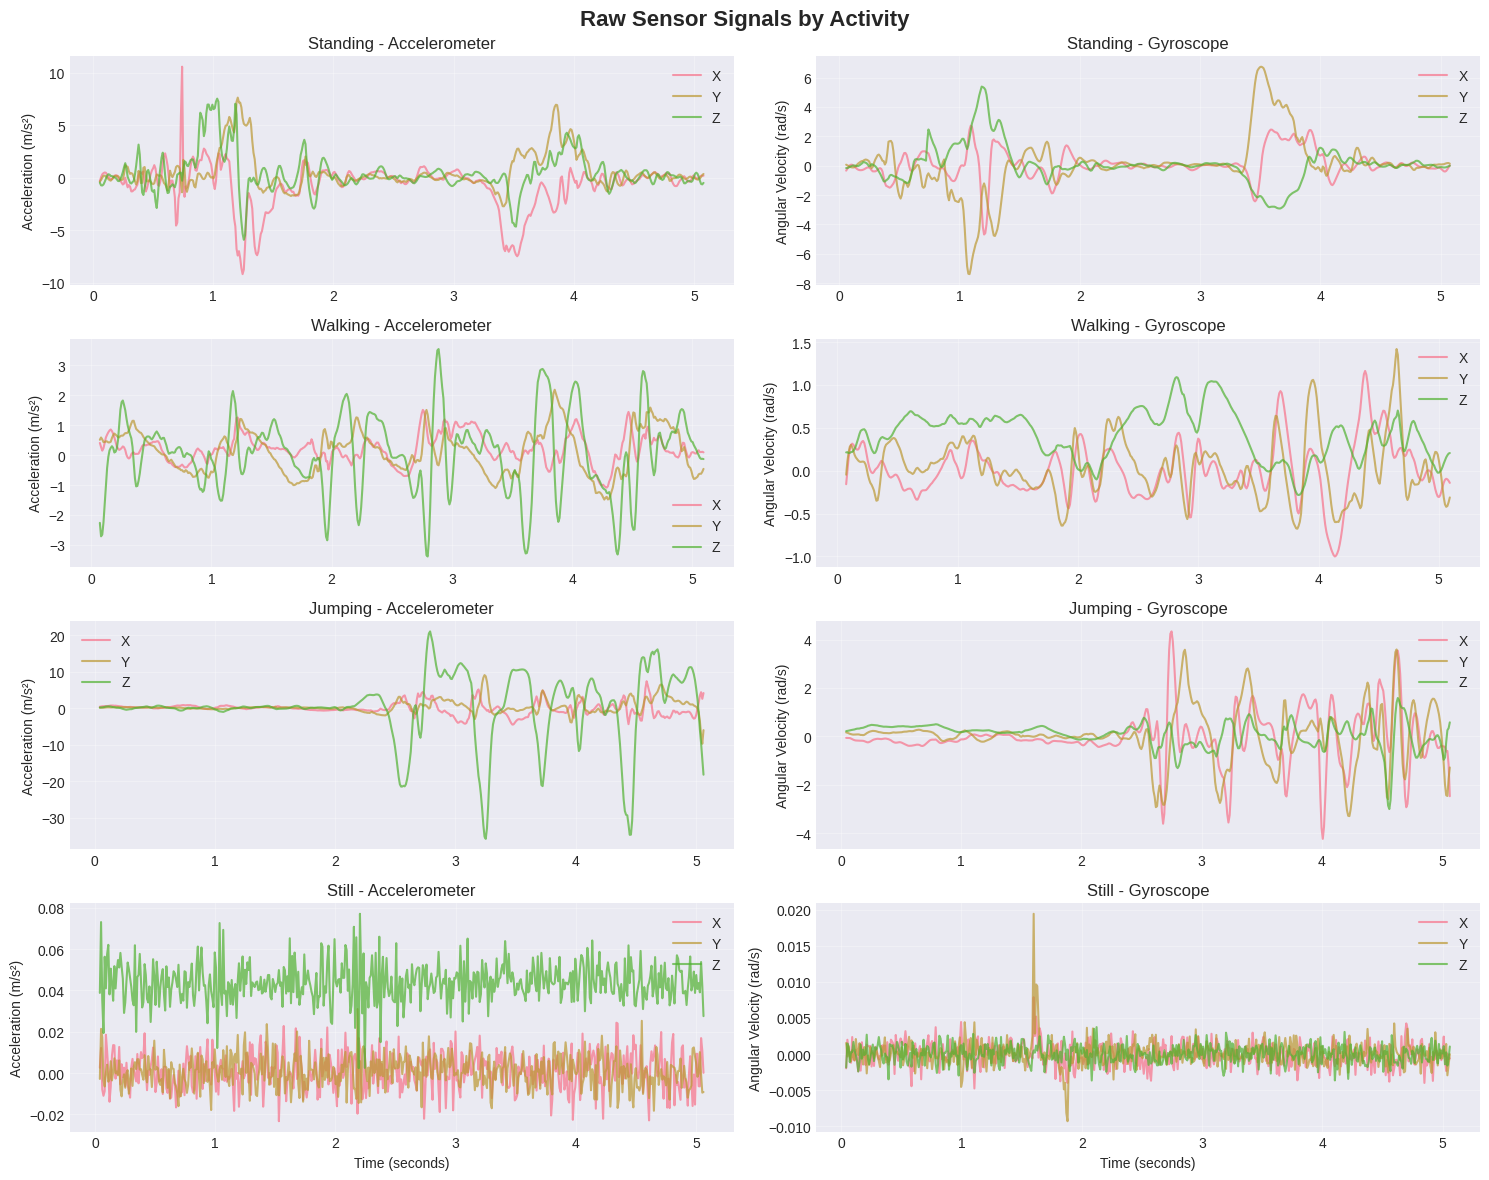

In [5]:
# Plot raw sensor data for each activity
fig, axes = plt.subplots(4, 2, figsize=(15, 12))
fig.suptitle('Raw Sensor Signals by Activity', fontsize=16, fontweight='bold')

for idx, activity in enumerate(ACTIVITIES):
    # Get first recording of this activity
    activity_data = df_all[df_all['activity'] == activity].head(500)
    
    # Plot accelerometer
    axes[idx, 0].plot(activity_data['seconds_elapsed'], activity_data['accel_x'], label='X', alpha=0.7)
    axes[idx, 0].plot(activity_data['seconds_elapsed'], activity_data['accel_y'], label='Y', alpha=0.7)
    axes[idx, 0].plot(activity_data['seconds_elapsed'], activity_data['accel_z'], label='Z', alpha=0.7)
    axes[idx, 0].set_title(f'{activity.capitalize()} - Accelerometer')
    axes[idx, 0].set_ylabel('Acceleration (m/s²)')
    axes[idx, 0].legend()
    axes[idx, 0].grid(True, alpha=0.3)
    
    # Plot gyroscope
    axes[idx, 1].plot(activity_data['seconds_elapsed'], activity_data['gyro_x'], label='X', alpha=0.7)
    axes[idx, 1].plot(activity_data['seconds_elapsed'], activity_data['gyro_y'], label='Y', alpha=0.7)
    axes[idx, 1].plot(activity_data['seconds_elapsed'], activity_data['gyro_z'], label='Z', alpha=0.7)
    axes[idx, 1].set_title(f'{activity.capitalize()} - Gyroscope')
    axes[idx, 1].set_ylabel('Angular Velocity (rad/s)')
    axes[idx, 1].legend()
    axes[idx, 1].grid(True, alpha=0.3)
    
    if idx == 3:
        axes[idx, 0].set_xlabel('Time (seconds)')
        axes[idx, 1].set_xlabel('Time (seconds)')

plt.tight_layout()
plt.savefig('mnt/user-data/outputs/raw_sensor_signals.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Feature Extraction

We'll extract both time-domain and frequency-domain features from the sensor data.

In [7]:
def extract_time_domain_features(window_data):
    """
    Extract time-domain features from a data window
    """
    features = {}
    
    # Features for each axis
    axes = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
    
    for axis in axes:
        data = window_data[axis].values
        
        # Statistical features
        features[f'{axis}_mean'] = np.mean(data)
        features[f'{axis}_std'] = np.std(data)
        features[f'{axis}_var'] = np.var(data)
        features[f'{axis}_min'] = np.min(data)
        features[f'{axis}_max'] = np.max(data)
        features[f'{axis}_range'] = np.max(data) - np.min(data)
        features[f'{axis}_median'] = np.median(data)
        features[f'{axis}_skew'] = skew(data)
        features[f'{axis}_kurtosis'] = kurtosis(data)
        
        # Root mean square
        features[f'{axis}_rms'] = np.sqrt(np.mean(data**2))
    
    # Signal Magnitude Area (SMA)
    sma_accel = (np.sum(np.abs(window_data['accel_x'])) + 
                 np.sum(np.abs(window_data['accel_y'])) + 
                 np.sum(np.abs(window_data['accel_z']))) / len(window_data)
    
    sma_gyro = (np.sum(np.abs(window_data['gyro_x'])) + 
                np.sum(np.abs(window_data['gyro_y'])) + 
                np.sum(np.abs(window_data['gyro_z']))) / len(window_data)
    
    features['sma_accel'] = sma_accel
    features['sma_gyro'] = sma_gyro
    
    # Correlation between axes
    features['corr_accel_xy'] = np.corrcoef(window_data['accel_x'], window_data['accel_y'])[0, 1]
    features['corr_accel_xz'] = np.corrcoef(window_data['accel_x'], window_data['accel_z'])[0, 1]
    features['corr_accel_yz'] = np.corrcoef(window_data['accel_y'], window_data['accel_z'])[0, 1]
    
    return features

def extract_frequency_domain_features(window_data, sampling_rate=100):
    """
    Extract frequency-domain features using FFT
    """
    features = {}
    axes = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
    
    for axis in axes:
        data = window_data[axis].values
        n = len(data)
        
        # Compute FFT
        fft_vals = fft(data)
        fft_magnitude = np.abs(fft_vals[:n//2])
        freqs = fftfreq(n, 1/sampling_rate)[:n//2]
        
        # Dominant frequency
        if len(fft_magnitude) > 0:
            dominant_freq_idx = np.argmax(fft_magnitude)
            features[f'{axis}_dominant_freq'] = freqs[dominant_freq_idx]
            
            # Spectral energy
            features[f'{axis}_spectral_energy'] = np.sum(fft_magnitude**2)
            
            # Spectral entropy
            psd = fft_magnitude**2
            psd_norm = psd / np.sum(psd)
            psd_norm = psd_norm[psd_norm > 0]  # Remove zeros for log
            features[f'{axis}_spectral_entropy'] = -np.sum(psd_norm * np.log2(psd_norm))
        else:
            features[f'{axis}_dominant_freq'] = 0
            features[f'{axis}_spectral_energy'] = 0
            features[f'{axis}_spectral_entropy'] = 0
    
    return features

def create_windows(df, window_size=100, overlap=0.5):
    """
    Create sliding windows from the data
    window_size: number of samples per window
    overlap: fraction of overlap between windows
    """
    step_size = int(window_size * (1 - overlap))
    windows = []
    
    for activity in ACTIVITIES:
        activity_data = df[df['activity'] == activity]
        
        # Get unique recordings
        recordings = activity_data['recording'].unique()
        
        for rec in recordings:
            rec_data = activity_data[activity_data['recording'] == rec].reset_index(drop=True)
            
            # Create windows
            for i in range(0, len(rec_data) - window_size, step_size):
                window = rec_data.iloc[i:i+window_size]
                windows.append({
                    'data': window,
                    'activity': activity,
                    'recording': rec
                })
    
    return windows

def extract_features_from_windows(windows):
    """
    Extract all features from windows
    """
    feature_list = []
    
    print(f"Extracting features from {len(windows)} windows...")
    
    for idx, window_dict in enumerate(windows):
        window_data = window_dict['data']
        
        # Extract features
        time_features = extract_time_domain_features(window_data)
        freq_features = extract_frequency_domain_features(window_data)
        
        # Combine features
        all_features = {**time_features, **freq_features}
        all_features['activity'] = window_dict['activity']
        all_features['recording'] = window_dict['recording']
        
        feature_list.append(all_features)
        
        if (idx + 1) % 100 == 0:
            print(f"  Processed {idx + 1}/{len(windows)} windows")
    
    return pd.DataFrame(feature_list)

# Create windows
print("Creating sliding windows...")
windows = create_windows(df_all, window_size=100, overlap=0.5)
print(f"Created {len(windows)} windows\n")

# Extract features
features_df = extract_features_from_windows(windows)

print(f"\n✓ Feature extraction complete")
print(f"Feature matrix shape: {features_df.shape}")
print(f"Number of features: {features_df.shape[1] - 2}")

# Display sample features
features_df.head()

Creating sliding windows...
Created 342 windows

Extracting features from 342 windows...


  Processed 100/342 windows
  Processed 200/342 windows
  Processed 300/342 windows

✓ Feature extraction complete
Feature matrix shape: (342, 85)
Number of features: 83


,accel_x_mean,accel_x_std,accel_x_var,accel_x_min,accel_x_max,accel_x_range,accel_x_median,accel_x_skew,accel_x_kurtosis,accel_x_rms,...,gyro_x_spectral_energy,gyro_x_spectral_entropy,gyro_y_dominant_freq,gyro_y_spectral_energy,gyro_y_spectral_entropy,gyro_z_dominant_freq,gyro_z_spectral_energy,gyro_z_spectral_entropy,activity,recording
0,0.323247,1.736357,3.014935,-4.554129,10.577924,15.132053,0.106511,2.016893,11.651999,1.766189,...,2077.477695,2.701535,0.0,11302.890378,3.233227,1.0,4506.147543,2.433196,standing,1
1,-1.219931,3.412686,11.646427,-9.177492,10.577924,19.755417,-0.786879,-0.185998,0.527111,3.624177,...,9078.049329,2.769195,0.0,56616.024260,1.775155,0.0,34628.701969,1.608587,standing,1
2,-1.757742,2.769451,7.669859,-9.177492,2.263726,11.441218,-1.167314,-0.936307,0.087548,3.280170,...,10109.500786,2.789265,1.0,39819.153532,2.626105,1.0,25758.018917,1.862577,standing,1
3,-0.084760,0.785736,0.617381,-1.737425,1.683579,3.421004,0.061082,-0.302501,-0.408204,0.790294,...,2080.534085,2.832293,3.0,1849.401502,2.874927,2.0,585.449393,2.993303,standing,1
4,0.150771,0.449353,0.201918,-0.898711,1.098859,1.997570,0.113795,-0.018675,-0.644033,0.473973,...,113.296710,2.860309,3.0,133.614387,2.525386,3.0,94.522739,3.453412,standing,1


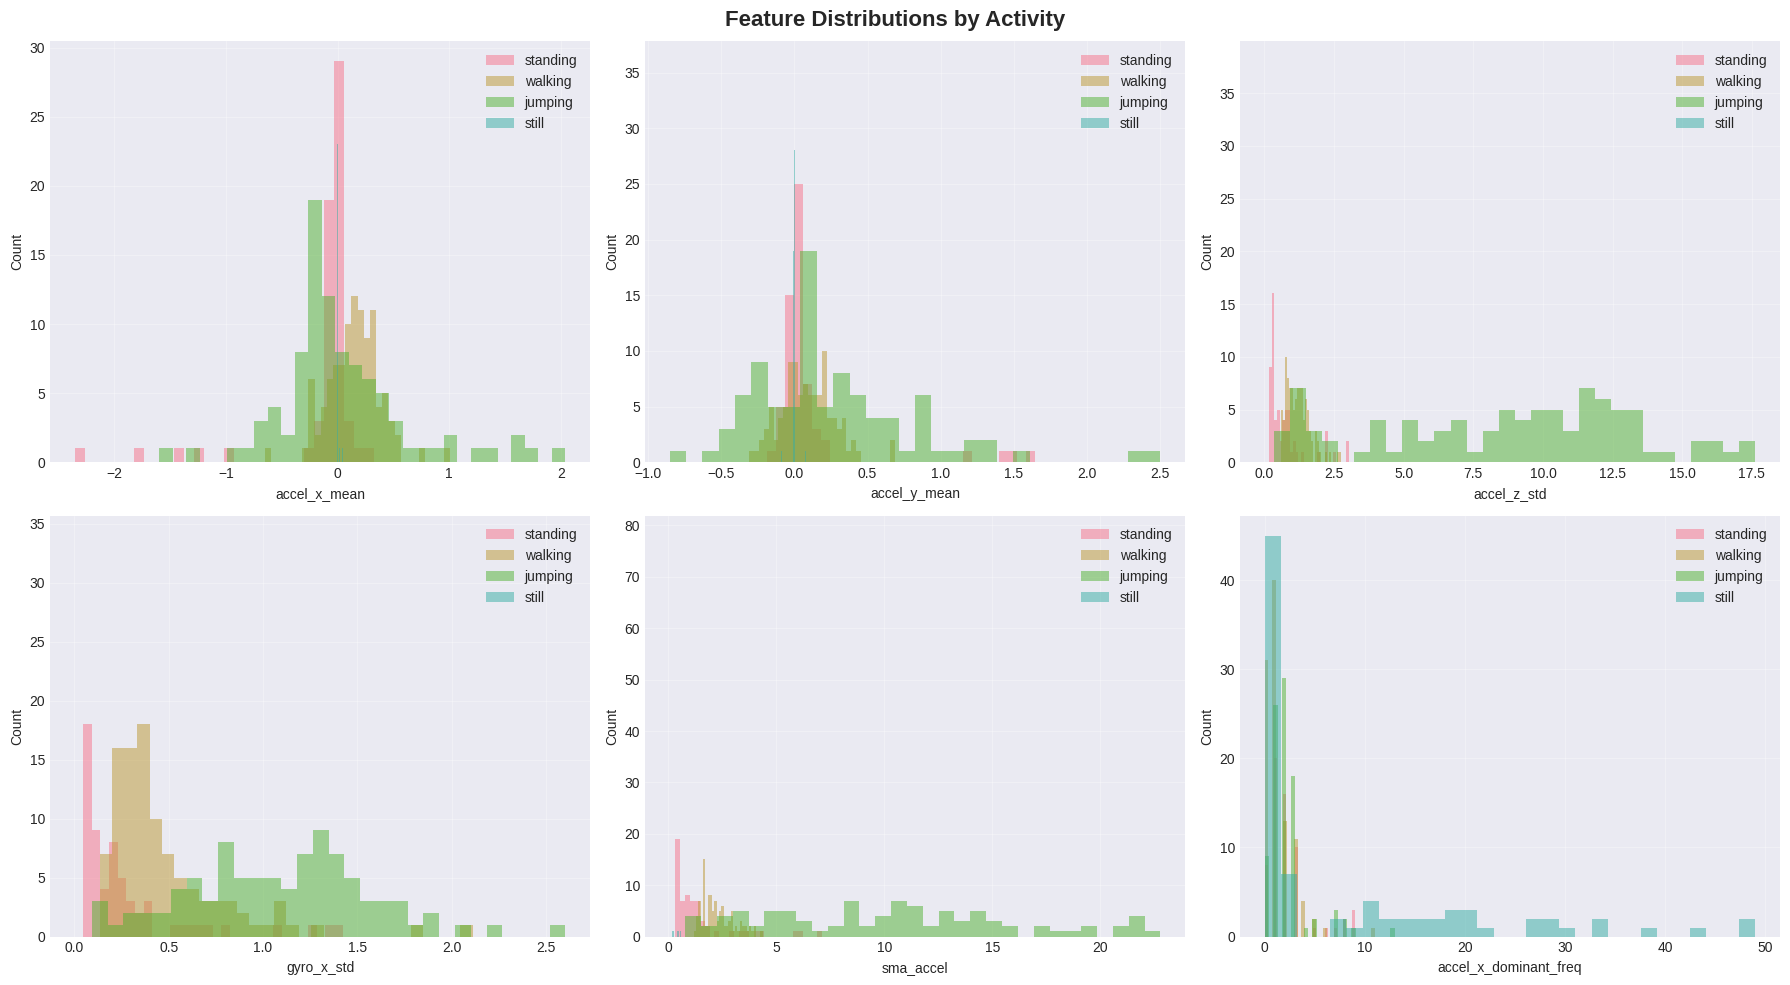

In [8]:
# Visualize feature distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Feature Distributions by Activity', fontsize=16, fontweight='bold')

# Select some key features to visualize
key_features = ['accel_x_mean', 'accel_y_mean', 'accel_z_std', 
                'gyro_x_std', 'sma_accel', 'accel_x_dominant_freq']

for idx, feature in enumerate(key_features):
    ax = axes[idx // 3, idx % 3]
    
    for activity in ACTIVITIES:
        data = features_df[features_df['activity'] == activity][feature]
        ax.hist(data, alpha=0.5, label=activity, bins=30)
    
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('mnt/user-data/outputs/feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Data Preparation for HMM

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Prepare features and labels
feature_columns = [col for col in features_df.columns if col not in ['activity', 'recording']]
X = features_df[feature_columns].values
y = features_df['activity'].values
recordings = features_df['recording'].values

# Encode activities as integers
activity_to_int = {activity: idx for idx, activity in enumerate(ACTIVITIES)}
int_to_activity = {idx: activity for activity, idx in activity_to_int.items()}
y_encoded = np.array([activity_to_int[activity] for activity in y])

print("Activity encoding:")
for activity, idx in activity_to_int.items():
    print(f"  {activity}: {idx}")

# Split data: use some recordings for training, others for testing
# We'll use recording numbers to split
unique_recordings = features_df.groupby(['activity', 'recording']).size().reset_index()

# For each activity, use first 3 recordings for training, last for testing
train_indices = []
test_indices = []

for activity in ACTIVITIES:
    activity_indices = features_df[features_df['activity'] == activity].index.tolist()
    activity_recordings = features_df[features_df['activity'] == activity]['recording'].unique()
    
    # Use 75% for training, 25% for testing
    n_train_recs = max(1, int(len(activity_recordings) * 0.75))
    train_recs = activity_recordings[:n_train_recs]
    test_recs = activity_recordings[n_train_recs:]
    
    train_idx = features_df[(features_df['activity'] == activity) & 
                            (features_df['recording'].isin(train_recs))].index.tolist()
    test_idx = features_df[(features_df['activity'] == activity) & 
                           (features_df['recording'].isin(test_recs))].index.tolist()
    
    train_indices.extend(train_idx)
    test_indices.extend(test_idx)

X_train = X[train_indices]
y_train = y_encoded[train_indices]
X_test = X[test_indices]
y_test = y_encoded[test_indices]

print(f"\nTraining set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✓ Data prepared for HMM")
print(f"Feature dimensions: {X_train_scaled.shape[1]}")

Activity encoding:
  standing: 0
  walking: 1
  jumping: 2
  still: 3

Training set: 250 samples
Test set: 92 samples

✓ Data prepared for HMM
Feature dimensions: 83


## 6. Hidden Markov Model Implementation

In [16]:
# Install hmmlearn if needed
%pip install hmmlearn --break-system-packages -q

Note: you may need to restart the kernel to use updated packages.


In [10]:
from hmmlearn import hmm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Initialize HMM parameters
N_STATES = len(ACTIVITIES)  # 4 hidden states (one per activity)

# Create a Gaussian HMM
model = hmm.GaussianHMM(
    n_components=N_STATES,
    covariance_type="diag",
    n_iter=100,
    random_state=42
)

# Fit the model
print("Training HMM...")
model.fit(X_train_scaled)
print("✓ HMM training complete\n")

# Display model parameters
print("\nHMM Parameters:")
print(f"Number of states: {model.n_components}")
print(f"Number of features: {model.n_features}")
print(f"\nInitial state probabilities (π):")
print(model.startprob_)

print(f"\nTransition matrix (A):")
print(model.transmat_)

Training HMM...
✓ HMM training complete


HMM Parameters:
Number of states: 4
Number of features: 83

Initial state probabilities (π):
[0.00000000e+000 1.00000000e+000 0.00000000e+000 1.45925316e-292]

Transition matrix (A):
[[1.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 7.08367508e-001 1.24991388e-001 1.66641104e-001]
 [0.00000000e+000 6.89686780e-002 9.31031322e-001 2.16700527e-092]
 [1.96075834e-002 1.37239837e-001 2.04782648e-262 8.43152580e-001]]


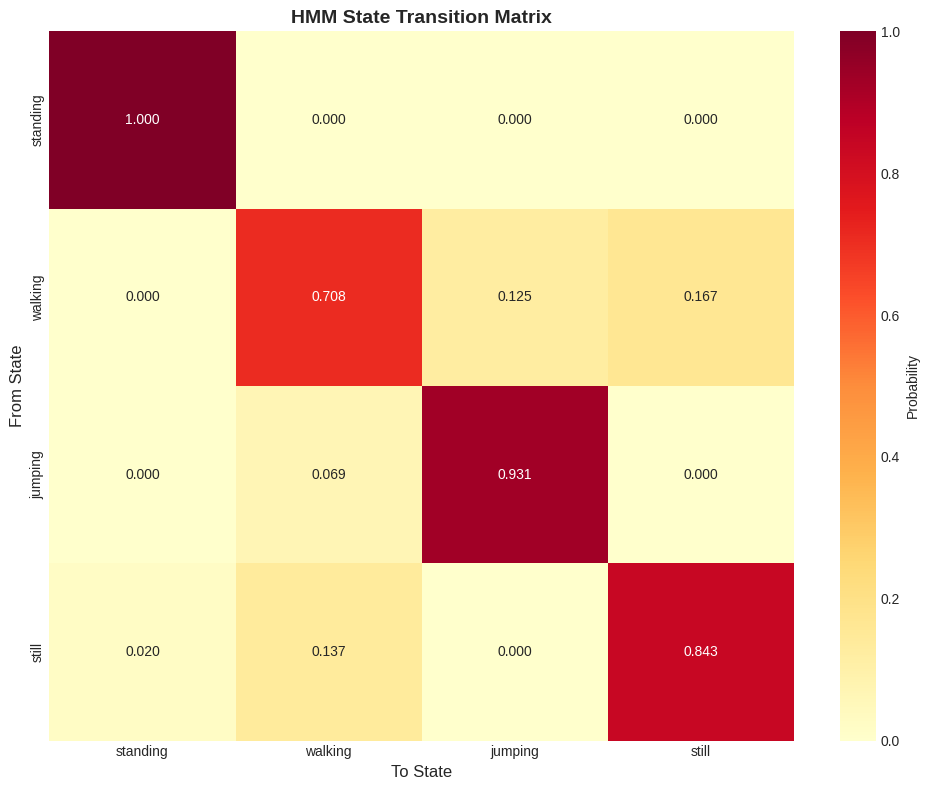

✓ Transition matrix visualized


In [11]:
# Visualize transition matrix
plt.figure(figsize=(10, 8))
sns.heatmap(model.transmat_, annot=True, fmt='.3f', cmap='YlOrRd',
            xticklabels=ACTIVITIES, yticklabels=ACTIVITIES,
            cbar_kws={'label': 'Probability'})
plt.title('HMM State Transition Matrix', fontsize=14, fontweight='bold')
plt.xlabel('To State', fontsize=12)
plt.ylabel('From State', fontsize=12)
plt.tight_layout()
plt.savefig('mnt/user-data/outputs/transition_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Transition matrix visualized")

## 7. Viterbi Algorithm - Decode Most Likely State Sequence

In [12]:
# Use Viterbi algorithm on test set
print("Running Viterbi algorithm on test set...")
y_pred = model.predict(X_test_scaled)
print("✓ Viterbi decoding complete\n")

# Map predicted states to activities
# The model doesn't know which state corresponds to which activity
# We need to map states to activities based on which activity is most common for each predicted state

def map_states_to_activities(y_true, y_pred):
    """
    Map HMM states to activity labels based on majority voting
    """
    state_to_activity = {}
    
    for state in range(N_STATES):
        # Find which true activity is most common for this predicted state
        state_mask = (y_pred == state)
        if np.sum(state_mask) > 0:
            true_labels = y_true[state_mask]
            most_common = np.bincount(true_labels).argmax()
            state_to_activity[state] = most_common
        else:
            state_to_activity[state] = state
    
    # Map predictions
    y_pred_mapped = np.array([state_to_activity[s] for s in y_pred])
    return y_pred_mapped, state_to_activity

y_pred_mapped, state_mapping = map_states_to_activities(y_test, y_pred)

print("State to Activity Mapping:")
for state, activity_idx in state_mapping.items():
    print(f"  State {state} → {int_to_activity[activity_idx]}")

Running Viterbi algorithm on test set...
✓ Viterbi decoding complete

State to Activity Mapping:
  State 0 → still
  State 1 → jumping
  State 2 → standing
  State 3 → jumping


## 8. Model Evaluation

In [13]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_mapped)
print(f"\nOverall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)\n")

# Classification report
print("Classification Report:")
print("="*60)
report = classification_report(y_test, y_pred_mapped, 
                              target_names=ACTIVITIES,
                              digits=4)
print(report)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_mapped)
print("\nConfusion Matrix:")
print(cm)


Overall Accuracy: 0.7609 (76.09%)

Classification Report:
              precision    recall  f1-score   support

    standing     0.5128    0.9524    0.6667        21
     walking     0.0000    0.0000    0.0000        21
     jumping     0.9062    1.0000    0.9508        29
       still     1.0000    1.0000    1.0000        21

    accuracy                         0.7609        92
   macro avg     0.6048    0.7381    0.6544        92
weighted avg     0.6310    0.7609    0.6801        92


Confusion Matrix:
[[20  0  1  0]
 [19  0  2  0]
 [ 0  0 29  0]
 [ 0  0  0 21]]


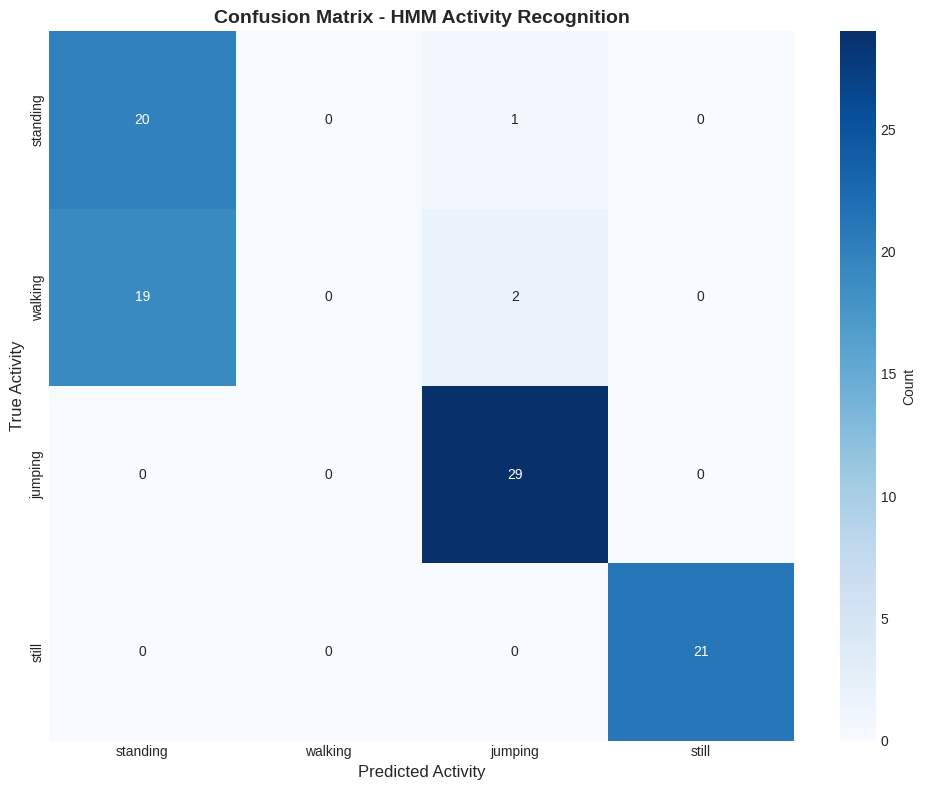

In [15]:
# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=ACTIVITIES, yticklabels=ACTIVITIES,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - HMM Activity Recognition', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Activity', fontsize=12)
plt.ylabel('True Activity', fontsize=12)
plt.tight_layout()
plt.savefig('mnt/user-data/outputs/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
# Calculate sensitivity and specificity for each activity
from sklearn.metrics import recall_score, precision_score

print("\nDetailed Metrics per Activity:")
print(f"{'Activity':<15} {'Samples':<10} {'Sensitivity':<15} {'Specificity':<15} {'Precision':<15}")

results_table = []

for idx, activity in enumerate(ACTIVITIES):
    # Create binary labels (current activity vs all others)
    y_true_binary = (y_test == idx).astype(int)
    y_pred_binary = (y_pred_mapped == idx).astype(int)
    
    # Calculate metrics
    n_samples = np.sum(y_true_binary)
    sensitivity = recall_score(y_true_binary, y_pred_binary, zero_division=0)
    
    # Specificity = TN / (TN + FP)
    tn = np.sum((y_true_binary == 0) & (y_pred_binary == 0))
    fp = np.sum((y_true_binary == 0) & (y_pred_binary == 1))
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    precision = precision_score(y_true_binary, y_pred_binary, zero_division=0)
    
    print(f"{activity:<15} {n_samples:<10} {sensitivity:<15.4f} {specificity:<15.4f} {precision:<15.4f}")
    
    results_table.append({
        'Activity': activity,
        'Number of Samples': n_samples,
        'Sensitivity': f"{sensitivity:.4f}",
        'Specificity': f"{specificity:.4f}",
        'Precision': f"{precision:.4f}"
    })

print(f"{'Overall Accuracy':<15} {'':<10} {'':<15} {'':<15} {accuracy:.4f}")

# Save results to DataFrame for the report
results_df = pd.DataFrame(results_table)
results_df.to_csv('mnt/user-data/outputs/evaluation_metrics.csv', index=False)
print("\n✓ Evaluation metrics saved")


Detailed Metrics per Activity:
Activity        Samples    Sensitivity     Specificity     Precision      
standing        21         0.9524          0.7324          0.5128         
walking         21         0.0000          1.0000          0.0000         
jumping         29         1.0000          0.9524          0.9062         
still           21         1.0000          1.0000          1.0000         
Overall Accuracy                                            0.7609

✓ Evaluation metrics saved


## 9. Visualize Decoded Sequences

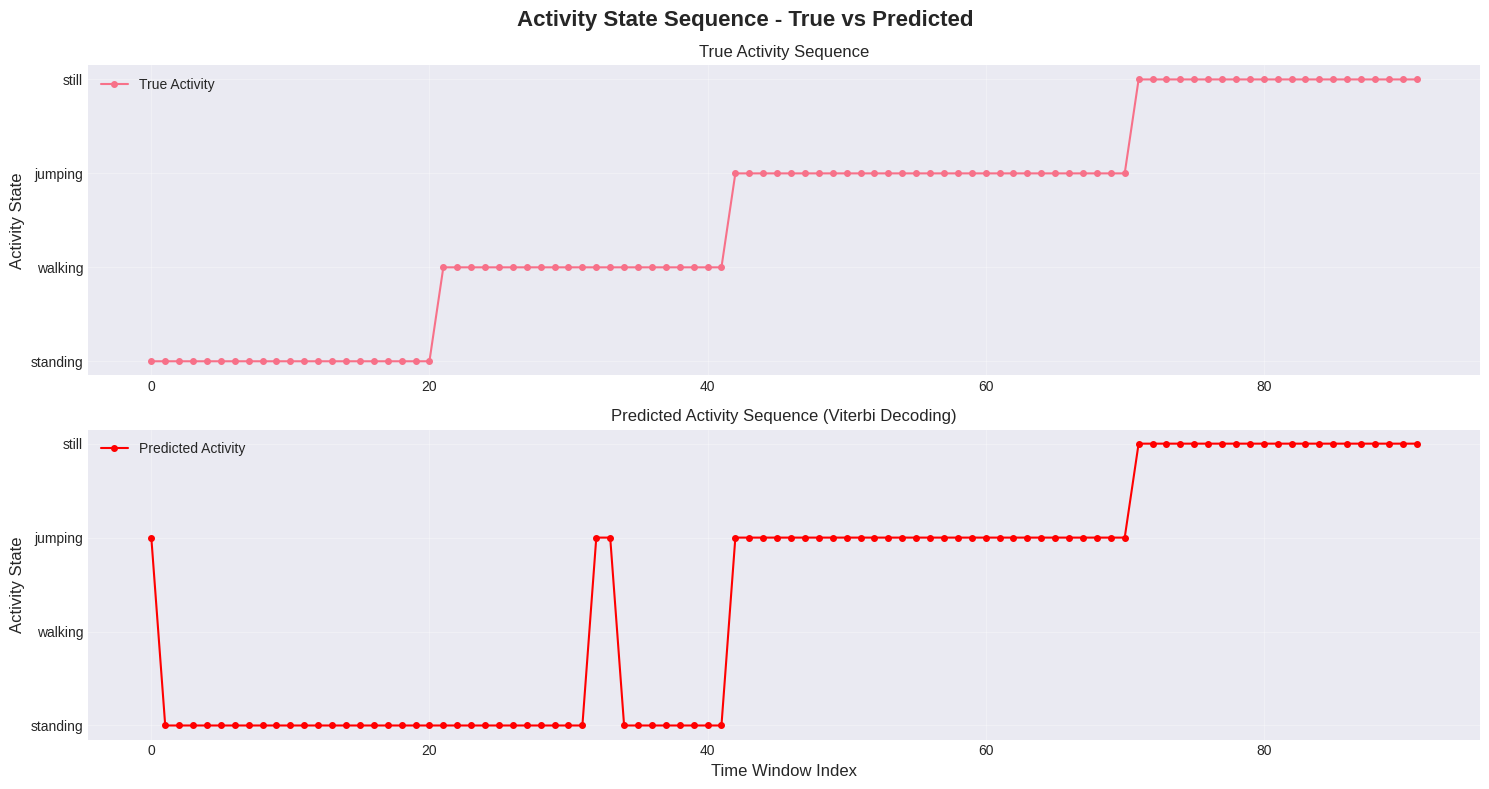

✓ Decoded sequences visualized


In [ ]:
# Plot predicted vs true activity sequences for a sample
sample_length = min(200, len(y_test))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
fig.suptitle('Activity State Sequence - True vs Predicted', fontsize=16, fontweight='bold')

# True sequence
ax1.plot(range(sample_length), y_test[:sample_length], 'o-', label='True Activity', markersize=4)
ax1.set_ylabel('Activity State', fontsize=12)
ax1.set_yticks(range(N_STATES))
ax1.set_yticklabels(ACTIVITIES)
ax1.set_title('True Activity Sequence')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Predicted sequence
ax2.plot(range(sample_length), y_pred_mapped[:sample_length], 'o-', 
         label='Predicted Activity', color='red', markersize=4)
ax2.set_xlabel('Time Window Index', fontsize=12)
ax2.set_ylabel('Activity State', fontsize=12)
ax2.set_yticks(range(N_STATES))
ax2.set_yticklabels(ACTIVITIES)
ax2.set_title('Predicted Activity Sequence (Viterbi Decoding)')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.savefig('mnt/user-data/outputs/decoded_sequences.png', dpi=300, bbox_inches='tight')
plt.show()

## 10. Analysis and Insights

In [21]:
print("ANALYSIS AND INSIGHTS")

print("\n1. ACTIVITY DISTINGUISHABILITY:")

# Analyze which activities are easiest/hardest to distinguish
from sklearn.metrics import f1_score

for idx, activity in enumerate(ACTIVITIES):
    y_true_binary = (y_test == idx).astype(int)
    y_pred_binary = (y_pred_mapped == idx).astype(int)
    f1 = f1_score(y_true_binary, y_pred_binary, zero_division=0)
    print(f"  {activity.capitalize():<15} F1-Score: {f1:.4f}")

print("\n2. TRANSITION PROBABILITY INSIGHTS:")
print("Most likely transitions:")
for i, from_activity in enumerate(ACTIVITIES):
    for j, to_activity in enumerate(ACTIVITIES):
        if model.transmat_[i, j] > 0.3 and i != j:
            print(f"  {from_activity} → {to_activity}: {model.transmat_[i, j]:.4f}")

print("\n3. COMMON MISCLASSIFICATIONS:")
for i in range(N_STATES):
    for j in range(N_STATES):
        if i != j and cm[i, j] > 0:
            error_rate = cm[i, j] / cm[i, :].sum() if cm[i, :].sum() > 0 else 0
            if error_rate > 0.1:  # Show if >10% error
                print(f"  {ACTIVITIES[i]} misclassified as {ACTIVITIES[j]}: "
                      f"{cm[i, j]} times ({error_rate*100:.1f}%)")

print("\n4. MODEL PERFORMANCE SUMMARY:")
print(f"  Overall Accuracy: {accuracy*100:.2f}%")
print(f"  Number of States: {N_STATES}")
print(f"  Number of Features: {X_train_scaled.shape[1]}")
print(f"  Training Samples: {len(X_train)}")
print(f"  Test Samples: {len(X_test)}")

ANALYSIS AND INSIGHTS

1. ACTIVITY DISTINGUISHABILITY:
  Standing        F1-Score: 0.6667
  Walking         F1-Score: 0.0000
  Jumping         F1-Score: 0.9508
  Still           F1-Score: 1.0000

2. TRANSITION PROBABILITY INSIGHTS:
Most likely transitions:

3. COMMON MISCLASSIFICATIONS:
  walking misclassified as standing: 19 times (90.5%)

4. MODEL PERFORMANCE SUMMARY:
  Overall Accuracy: 76.09%
  Number of States: 4
  Number of Features: 83
  Training Samples: 250
  Test Samples: 92


## 11. Recommendations for Improvement

### DATA COLLECTION:
- Collecting more samples, especially for activities with lower accuracy
- Increasing recording duration for better feature representation
- Including various participants for better generalization
- Various environmental conditions or surroundings (indoor/outdoor, different surfaces)

### FEATURE ENGINEERING:
- Include time-series features (autocorrelation, entropy measures)
- Experiment with different window sizes and overlap ratios
- Feature selection to reduce dimensionality and noise

### VALIDATION:
- Implement k-fold cross-validation
- Test on completely new participants
- Evaluate real-time performance
- Compare with other models (Random Forest, LSTM, CNN)

## 12. Save Model and Results

In [23]:
import pickle

# Save the trained model
with open('mnt/user-data/outputs/hmm_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Save the scaler
with open('mnt/user-data/outputs/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save state mapping
with open('mnt/user-data/outputs/state_mapping.pkl', 'wb') as f:
    pickle.dump(state_mapping, f)

# Save activity encoding
with open('mnt/user-data/outputs/activity_encoding.pkl', 'wb') as f:
    pickle.dump({'activity_to_int': activity_to_int, 'int_to_activity': int_to_activity}, f)

print("✓ Model and artifacts saved to /mnt/user-data/outputs/")

# Create a summary report
summary = {
    'Overall Accuracy': f"{accuracy:.4f}",
    'Number of States': N_STATES,
    'Number of Features': X_train_scaled.shape[1],
    'Training Samples': len(X_train),
    'Test Samples': len(X_test),
    'Activities': ACTIVITIES,
    'Sampling Rate': '100 Hz',
    'Window Size': 100,
    'Window Overlap': 0.5
}

summary_df = pd.DataFrame([summary])
summary_df.to_csv('mnt/user-data/outputs/model_summary.csv', index=False)


print("\nGenerated files in /mnt/user-data/outputs/:")
print("  1. raw_sensor_signals.png - Visualization of raw sensor data")
print("  2. feature_distributions.png - Feature distribution plots")
print("  3. transition_matrix.png - HMM transition probabilities")
print("  4. confusion_matrix.png - Model performance visualization")
print("  5. decoded_sequences.png - True vs predicted activity sequences")
print("  6. evaluation_metrics.csv - Detailed performance metrics")
print("  7. model_summary.csv - Model configuration summary")
print("  8. hmm_model.pkl - Trained HMM model")
print("  9. scaler.pkl - Feature scaler")
print(" 10. state_mapping.pkl - State-to-activity mapping")
print(" 11. activity_encoding.pkl - Activity encoding dictionary")

✓ Model and artifacts saved to /mnt/user-data/outputs/

Generated files in /mnt/user-data/outputs/:
  1. raw_sensor_signals.png - Visualization of raw sensor data
  2. feature_distributions.png - Feature distribution plots
  3. transition_matrix.png - HMM transition probabilities
  4. confusion_matrix.png - Model performance visualization
  5. decoded_sequences.png - True vs predicted activity sequences
  6. evaluation_metrics.csv - Detailed performance metrics
  7. model_summary.csv - Model configuration summary
  8. hmm_model.pkl - Trained HMM model
  9. scaler.pkl - Feature scaler
 10. state_mapping.pkl - State-to-activity mapping
 11. activity_encoding.pkl - Activity encoding dictionary
